In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread
import numpy as np
from napari_animated_gif_io import napari_write_image as imsave_animated_gif

cle.select_device("RTX")

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [2]:
original = cle.push(imread('../../data/Haase_MRT_tfl3d1.tif'))

original.shape

(192, 256, 256)

In [3]:
original.min(), original.max()

(0.0, 255.0)

In [4]:
# The algorithm shown below will only work if there are no zeros in the raw data.
# Furthermore, the animations only work if the raw data is in range [0, 255]
original = original * 254.0 / original.max() + 1
original.min(), original.max()

(1.0, 255.00002)

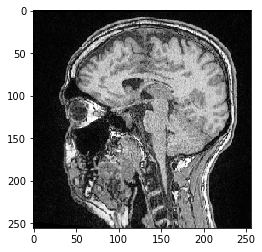

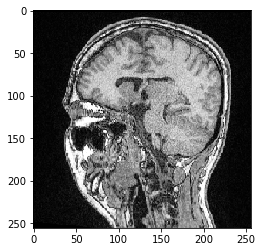

In [5]:
def acquire_slice_at_angle(image, angle):
    # rotate 3D stack and crop out a single center plane
    result = cle.create((1, image.shape[1],  image.shape[2]))
    
    transform = cle.AffineTransform3D()
    transform.center(image.shape)
    transform.rotate_around_y_axis(angle)
    transform.center(image.shape, undo=True)
    transform.translate(translate_z=-0.5 * image.shape[0])
    
    cle.affine_transform(image, result, transform=transform)
    
    return result

example = acquire_slice_at_angle(original, 15)
cle.imshow(example)
example = acquire_slice_at_angle(original, 30)
cle.imshow(example)

In [6]:
def acquire_stack(image, delta_angle):
    result = {}
    for angle in np.arange(0, 360, delta_angle):
        result[angle] = acquire_slice_at_angle(image, angle)
    
    return result

raw_stack = acquire_stack(original, 15)

In [7]:
demo = np.asarray(list(raw_stack.values())).astype(np.uint8)

imsave_animated_gif("demo_1.gif", demo, meta={})

![](demo_1.gif)

In [8]:
# create space for reconstructed image
first_image = raw_stack[0]
target = cle.create((256, first_image.shape[1], first_image.shape[2]))
cle.set(target, 0)
target.shape

(256, 256, 256)

In [9]:
def write_image_at_angle(source, target, angle):
    # rotate a single image around y-axis and store it
    # in the target 3D stack
    temp = cle.create_like(target)
        
    transform = cle.AffineTransform3D()
    transform.center(source.shape)
    transform.rotate_around_y_axis(-angle)
    transform.center(target.shape, undo=True)
    
    cle.affine_transform(source, temp, transform=transform)
    
    cle.maximum_images(target, temp, target)
    
    return target

def create_stack_from_angular_images(raw_stack, target):
    # Write images and multiple angles in to target stack
    demo = []
    for angle, image in raw_stack.items():
        write_image_at_angle(image, target, angle)

        demo.append(target[:,128,:])
    
    demo2 = np.asarray(demo).astype(np.uint8)
    imsave_animated_gif("demo_4.gif", demo2, meta={})

create_stack_from_angular_images(raw_stack, target)

![](demo_4.gif)

In [10]:
def fill_zero_gaps(image, num_max_iterations=100):
    # create memory we can reuse
    flip = cle.copy(image)
    flop = cle.create_like(flip)

    # the flag is used to store a single value: It will be 1 after
    # execution of the kernel in case any pixel was changed.
    flag = cle.create((1,1,1))

    demo = []
    result = None
    num_iterations = 0
    while True:
        cle.set(flag, 0)
        # use flip and flop alternating as source and target
        if num_iterations % 2 == 0:
            cle.onlyzero_overwrite_maximum_diamond(flip, flag, flop)
            result = flop
        else:
            cle.onlyzero_overwrite_maximum_diamond(flop, flag, flip)
            result = flip
        
        # read out flag
        flag_value = cle.pull(flag)[0][0][0] == 0
        num_iterations = num_iterations + 1
        if flag_value or num_max_iterations - num_iterations == 0:
            break
        
        demo.append(result[:,128,:])
    
    # demo visualization
    demo2 = np.asarray(demo).astype(np.uint8)
    imsave_animated_gif("demo_7.gif", demo2, meta={})
    return result

result = fill_zero_gaps(target)

![](demo_7.gif)

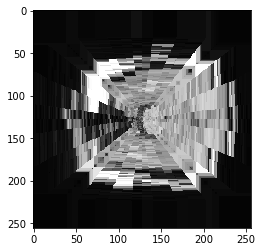

In [11]:
cle.imshow(result[:,128,:])

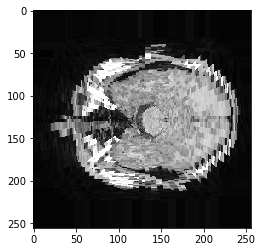

In [12]:
raw_stack = acquire_stack(original, 5)

target = cle.create((256, first_image.shape[1], first_image.shape[2]))
cle.set(target, 0)

create_stack_from_angular_images(raw_stack, target)

result = fill_zero_gaps(target)

cle.imshow(result[:,128,:])

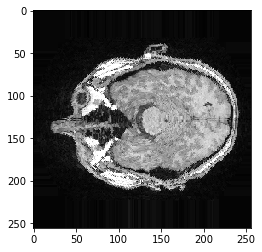

In [13]:
raw_stack = acquire_stack(original, 1)

target = cle.create((256, first_image.shape[1], first_image.shape[2]))
cle.set(target, 0)

create_stack_from_angular_images(raw_stack, target)

result = fill_zero_gaps(target)

cle.imshow(result[:,128,:])